In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import pandas as pd
from astropy.io import ascii
import corner
import tqdm

  0%|          | 0/50000 [00:00<?, ?it/s]

/home/nirav24/.local/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [00:25<00:00, 1999.68it/s]


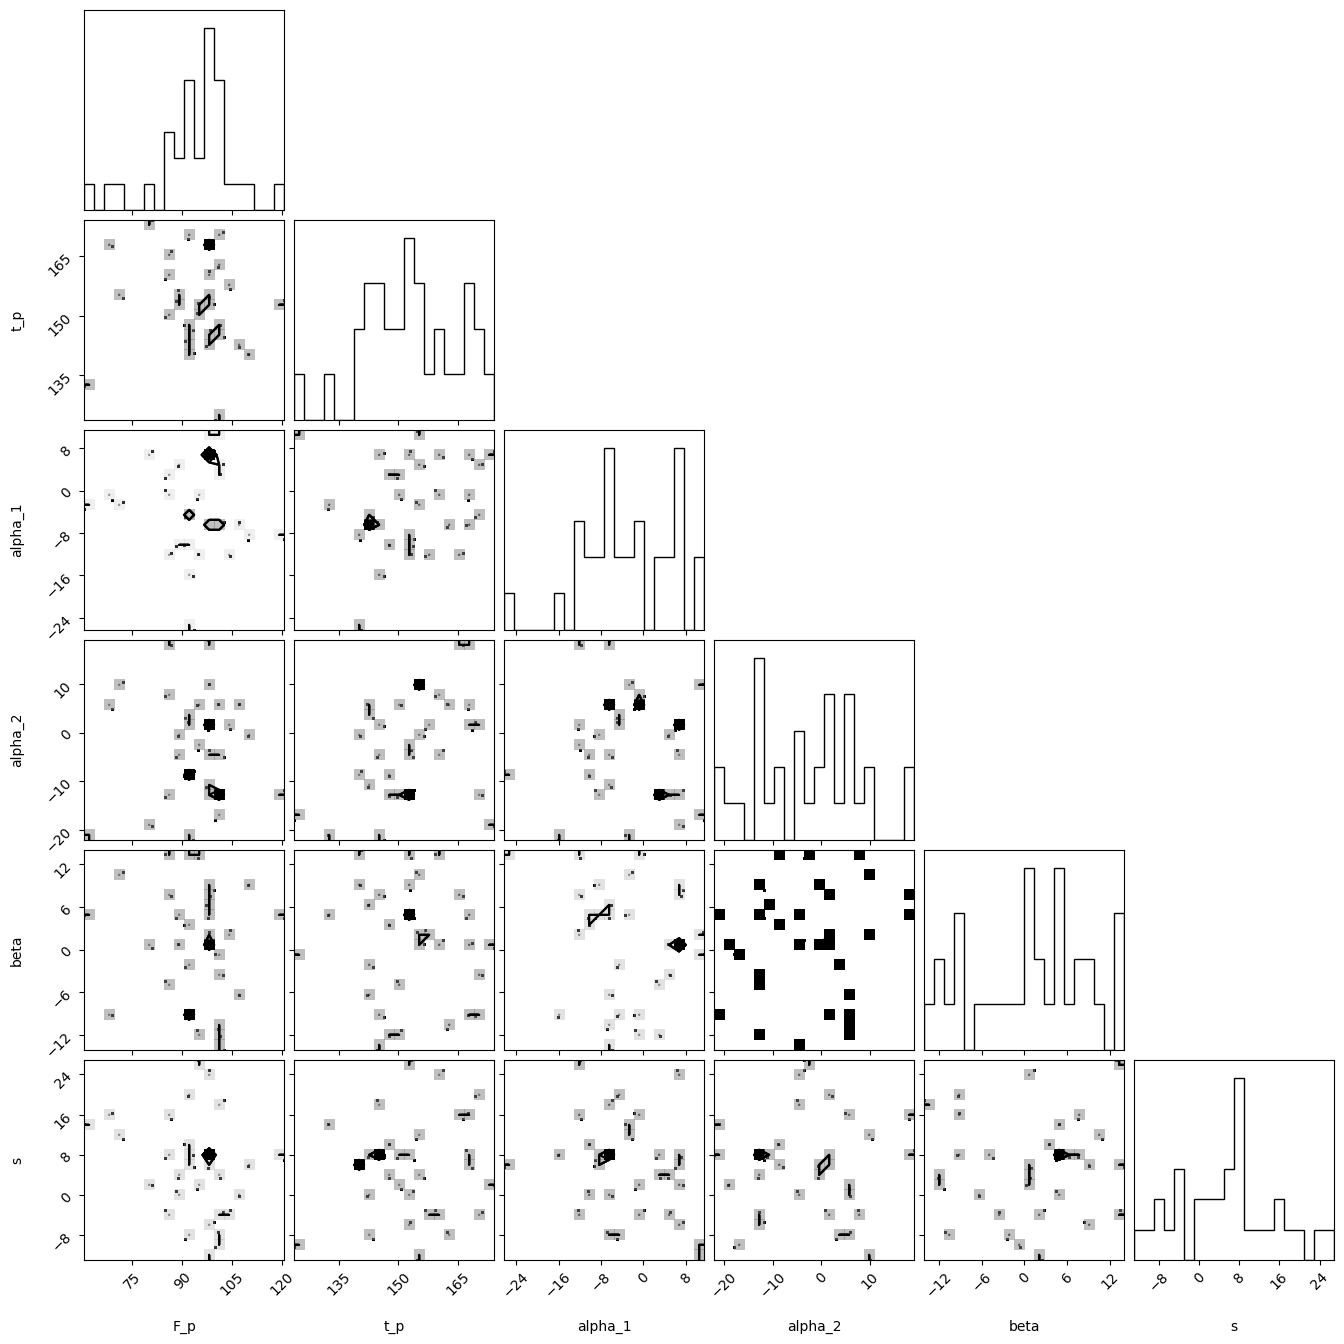

F_p = 96.00524261723702 +6.217456438354105 -11.077326634964862
t_p = 153.456377729101 +13.458005759290586 -11.22361892564274
alpha_1 = -4.2117159183352895 +10.55608498766997 -6.194402649940524
alpha_2 = -2.1377322672162977 +8.008443692316902 -10.931191867266474
beta = 1.8563704639173653 +6.567090611093219 -11.180682162297906
s = 5.676158623154764 +9.502630269320152 -9.013292520033549


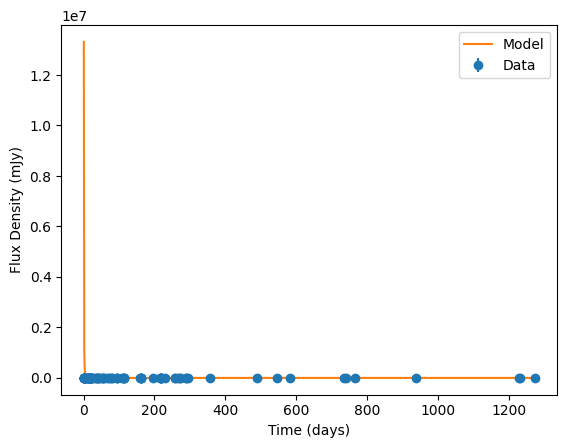

In [3]:
# Read and prepare data
file_path = './Data/gw170817_afterglow_data_full.txt'
data = ascii.read(file_path).to_pandas()

# Filter and adjust VLA data
vla_data = data[data['Telescope'] == 'VLA']
vla_data.loc[:, 'FluxD'] = pd.to_numeric(vla_data['FluxD'])
vla_data.loc[:, 'FluxDErr'] = pd.to_numeric(vla_data['FluxDErr'])
vla_data.loc[:, 'Freq'] = pd.to_numeric(vla_data['Freq'])
vla_data.loc[:, 'FluxD'] *= (vla_data['Freq'] / 3.000000e+09)**0.584
vla_data.loc[:, 'Freq'] = 3.000000e+09

# Filter and adjust Chandra data
chandra_data = data[data['Telescope'] == 'Chandra']
chandra_data.loc[:, 'FluxD'] = pd.to_numeric(chandra_data['FluxD'])
chandra_data.loc[:, 'FluxDErr'] = pd.to_numeric(chandra_data['FluxDErr'])
chandra_data.loc[:, 'Freq'] = pd.to_numeric(chandra_data['Freq'])
chandra_data.loc[:, 'FluxD'] *= (chandra_data['Freq'] / 3.000000e+09)**0.584
chandra_data.loc[:, 'Freq'] = 3.000000e+09

# Combine datasets
combined_data = pd.concat([vla_data, chandra_data])

# Define model
def smooth_broken_power_law(t, nu, F_p, t_p, alpha_1, alpha_2, beta, s):
    return (2**(-1/s)) * ((nu / 3.000000e+09) ** beta) * F_p * (((t/t_p) ** (-s * alpha_1) + (t/t_p) ** (-s * alpha_2)) ** (-1/s))

# Define log likelihood
def log_likelihood(theta, t, nu, F, F_err):
    F_model = smooth_broken_power_law(t, nu, *theta)
    return -0.5 * np.sum(((F - F_model) / F_err) ** 2)

# Define log prior
def log_prior(theta):
    F_p, t_p, alpha_1, alpha_2, beta, s = theta
    if 95 < F_p < 105 and 150 < t_p < 160 and 0.8 < alpha_1 < 0.9 and -2.05 < alpha_2 < -1.8 and -0.59 < beta < -0.57 and 10**(0.45) < s < 10**(0.7):
        return 0.0
    return -np.inf

# Define log probability
def log_probability(theta, t, nu, F, F_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, nu, F, F_err)

# Prepare data for fitting
t = combined_data['T'].values
nu = combined_data['Freq'].values
F = combined_data['FluxD'].values
F_err = combined_data['FluxDErr'].values

# Set up the sampler
ndim = 6
nwalkers = 32
nsteps = 50000
pos = [np.array([95, 155, 0.85, -1.90, -0.58, 10**0.55]) + 10*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(t, nu, F, F_err))

# Run the sampler
for _ in tqdm.tqdm(sampler.sample(pos, iterations=nsteps), total=nsteps):
    pass

# Extract and plot results
samples = sampler.get_chain(discard=100, flat=True)
fig = corner.corner(samples, labels=['F_p', 't_p', 'alpha_1', 'alpha_2', 'beta', 's'])
plt.show()

# Compute and print median values
F_p, t_p, alpha_1, alpha_2, beta, s = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print(f'F_p = {F_p[0]} +{F_p[1]} -{F_p[2]}')
print(f't_p = {t_p[0]} +{t_p[1]} -{t_p[2]}')
print(f'alpha_1 = {alpha_1[0]} +{alpha_1[1]} -{alpha_1[2]}')
print(f'alpha_2 = {alpha_2[0]} +{alpha_2[1]} -{alpha_2[2]}')
print(f'beta = {beta[0]} +{beta[1]} -{beta[2]}')
print(f's = {s[0]} +{s[1]} -{s[2]}')

# Plot the model
t_model = np.linspace(min(t), max(t), 1000)  # Adjust range to fit data
nu_model = 3.000000e+09
F_model = smooth_broken_power_law(t_model, nu_model, F_p[0], t_p[0], alpha_1[0], alpha_2[0], beta[0], s[0])
plt.errorbar(t, F, yerr=F_err, fmt='o', label='Data')
plt.plot(t_model, F_model, label='Model')
plt.xlabel('Time (days)')
plt.ylabel('Flux Density (mJy)')
plt.legend()
plt.show()